<a href="https://colab.research.google.com/github/developerdatascience/AMEX_Default_Prediction/blob/main/Pytorch_lemons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Option 1 – Use Google Colab (Simplest Way)

In order to complete this tutorial using Google Colab:

* Watch our free tutorial on Google Colab Overview (optional)
* Head over to Google Colab and load the starter notebook by clicking on the link below
https://colab.research.google.com/github/LeakyAI/BirdDetector/blob/main/BirdDetector%20-%20START%20HERE.ipynb
* Follow along the video tutorial above to complete the notebook

# Step 1 - Setup our Environment

In [1]:
import numpy as np
import pandas as pd


import torch
from torch import nn

import matplotlib.pyplot as plt

torch.__version__

'1.12.1+cu113'

In [2]:
## Check Processing Capability

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('A {} device was detected.'.format(device)) 

# Print the name of the cuda device, if detected
if device=='cuda':
  print (torch.cuda.get_device_name(device=device))

A cuda device was detected.
Tesla T4


# Step 2 - Download and Prepare our Dataset

In [3]:
url = 'https://raw.githubusercontent.com/LeakyAI/FirstNeuralNet/main/lemons.csv'
df = pd.read_csv(url)

# Explore the first 10 rows of the dataset
df.head(10)

# Check the size/shape of our dataset
df.shape

(365, 6)

### Create our Inputs and Outputs for Training our Neural Network

The data has been collected in a table with the following columns: Weekend, Sunny, Warm, BigSign, Price and NumberSold.  While the dataset is more or less ready to be used, we have two fields (Price and NumberSold) that contain real values. Usually, it's easier to train neural networks if the values are in the range of -1..1. To accomplish this, we will simply need to standardize both values (Price and NumberSold).

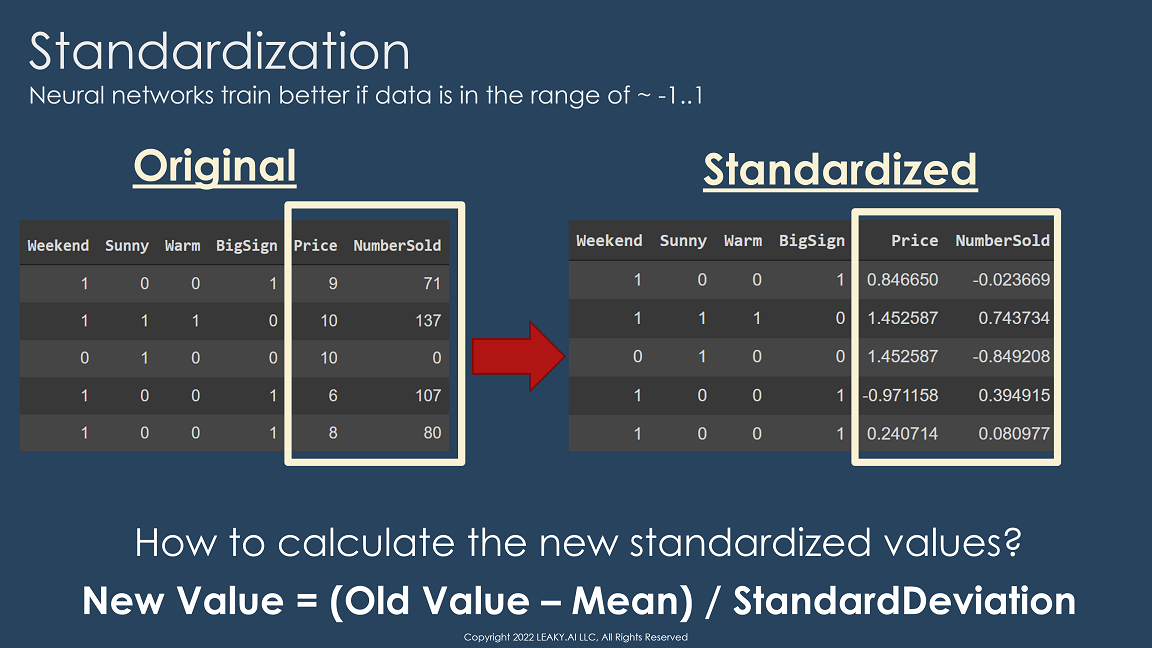

In [8]:
# Calculate the mean and standard deviation of the price column, then standardize the price column
priceMean = df['Price'].mean()
priceStd = df['Price'].std()
df['Price'] = (df['Price']-priceMean)/priceStd

# Calculate the mean and standard deviation of the numSold column, then standardize numSold
numSoldMean = df['NumberSold'].mean()
numSoldStd = df['NumberSold'].std()
df['NumberSold'] = (df['NumberSold']-numSoldMean)/numSoldStd

### Create our Input (x) and Output (y) to Train our Neural Network

Here you will create the input (x) and output (y) data needed to train our network. The number we want our neural network to predict is the column called 'NumberSold'. This will be the output (y). We will need to separate our input (Weekend, Sunny, Warm, BigSign, Price) from the output (NumberSold).  Here we will use PyTorch tensors which are just multi-dimensional arrays where all values must be of the same type (usually floats).

In [9]:
# Create our PyTorch tensors and move to CPU or GPU if available
# Extract the inputs and create a PyTorch tensor x (inputs)
inputs = ['Weekend','Sunny','Warm','BigSign','Price']
x = torch.tensor(df[inputs].values,dtype=torch.float, device=device)

# Extract the outputs and create a PyTorch tensor y (outputs)
outputs = ['NumberSold']
y = torch.tensor(df[outputs].values,dtype=torch.float, device=device)

# Explore the first 5 inputs
x[0:5]
# Explore the first 5 outputs
y[0:5]

tensor([[-0.0237],
        [ 0.7437],
        [-0.8492],
        [ 0.3949],
        [ 0.0810]], device='cuda:0')

# Step 3 - Build your Neural Network

Below you will build a simple neural network that will take as input the 5 input values above ('Weekend', 'Sunny', 'Warm', 'BigSign', 'Price') and produce a single value as an output. This network has a single hidden layer of 100 units.

In [6]:
# Define your PyTorch neural network
# Number of Inputs: 5
# Number of Hidden Units: 100
# Number of Hidden Layers: 1
# Activation Function:  Relu
# Number of Outputs: 1


model = nn.Sequential(
            nn.Linear(5,100),
            nn.ReLU(),
            nn.Linear(100,1)
        )

# Move it to either the CPU or GPU depending on what we have available
model.to(device)

Sequential(
  (0): Linear(in_features=5, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

# Step 4 - Train your Neural Network

Here we will train our neural network on the dataset (our set of inputs and outputs above).  The training loop will adjust the weights within our neural network to make it able to predict our number of lemonades sold during the training process.

In [10]:
import torch.optim as optim

# Measure our neural network by mean square error
criterion = torch.nn.MSELoss()

# Train our network with a simple SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train our network a using the entire dataset 5 times
for epoch in range(5):
    totalLoss = 0
    for i in range(len(x)):
       # Single Forward Pass
        ypred = model(x[i])

        # Measure how well the model predicted vs the actual value
        loss = criterion(ypred, y[i])

        # Track how well the model predicted (called loss)
        totalLoss+=loss.item()

        # Update the neural network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print out our loss after each training iteration
    print ("Total Loss: ", totalLoss)

Total Loss:  103.78779900097562
Total Loss:  6.916499282326065
Total Loss:  4.444681429266396
Total Loss:  3.367590648097874
Total Loss:  2.5211530587969406


# Step 5 - Analyze the Network's Performance

Now, the next thing we want to do is analyze the network's performance. That is, how well is our network able to make predictions?  We can do that by making a simple plot with the bottom axis showing the actual number of lemonades sold on a particular day and the other with the number of lemonades predicted by our neural network.  If the network is able to make good predictions, we should see a relatively simple straight line of dots!

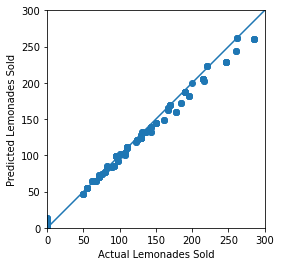

In [11]:
# Plot predictions vs. true values
@torch.no_grad()
def graphPredictions(model, x, y , minValue, maxValue):
    model.eval()                               # Set the model to inference mode

    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels

    x.to(device)
    y.to(device)
    model.to(device)

    for i in range(len(x)):
        # Single forward pass
        pred = model(x[i])                               
        
        # Un-normalize our prediction
        pred = pred*numSoldStd+numSoldMean
        act = y[i]*numSoldStd+numSoldMean

        # Save prediction and actual label
        predictions.append(pred.tolist())
        actual.append(act.item())

    # Plot actuals vs predictions
    plt.scatter(actual, predictions)
    plt.xlabel('Actual Lemonades Sold')
    plt.ylabel('Predicted Lemonades Sold')
    plt.plot([minValue,maxValue], [minValue,maxValue])
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)

    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

graphPredictions(model, x, y, 0, 300)


Wow, our neural network did a really good job learning how to predict the number of lemonades sold based on all the inputs.  With a chart like the one above, the closer the dots are to the line, the better the neural network predicted the number of lemonades sold compared to the actual number for that day. 

# Step 6 - Test with Your Own Predictions

Since our network is now trained, we can use it to make new predictions by passing in new input values.  Since we have a synthetic dataset, we are able to evaluate the accuracy of the result.

In [12]:
# Below we use the synthetic data generator formula to
# determine what the actual result should have been.
def datasetGenerator(weekend, sunny, warm, bigsign, price):
    numlemonssold = 0
    if weekend:
        numlemonssold = (sunny*5  + int(500 / price))
        if bigsign:
            numlemonssold = 1.3 * numlemonssold
        if warm:
            numlemonssold = 2 * numlemonssold
        if sunny:
            numlemonssold = 1.25 * numlemonssold
    numlemonssold = int(numlemonssold)   

    return numlemonssold

# Data that affects the number of lemons sold in one day
weekend = 1
sunny = 0
warm = 0   
bigsign = 1
price = 5

# Calculate what would have been the actual result using
# the synthetic dataset's algorithm
actual = datasetGenerator(weekend, sunny, warm, bigsign, price)

# Use the CPU as we just need to do a single pass
model.to('cpu')

# Normalize our inputs using the same values for our training
price = (price - priceMean) / priceStd

# Create our input tensor
x1 = torch.tensor([weekend, sunny, warm, bigsign, price],dtype=float)

# Pass the input into the neural network
y1 = model(x1.float())

# Un-normalize our output y1
y1 = y1*numSoldStd+numSoldMean

# Compare what your network predicted to the actual
print ("Neural Network Predicts: ", y1.item())
print ("Actual Result: ", actual)

Neural Network Predicts:  127.73202514648438
Actual Result:  130
